# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science: 

## Homework 2: Linear and k-NN Regression


**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner

<hr style="height:2pt">


In [2]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment follow the instructions given in canvas.
- As much as possible, try and stick to the hints and functions we import at the top of the homework, as those are the ideas and tools the class supports and is aiming to teach. And if a problem specifies a particular library you're required to use that library, and possibly others from the import list.
- Restart the kernel and run the whole notebook again before you submit. 
- Please use .head() when viewing data. Do not submit a notebook that is excessively long because output was not suppressed.

<hr style="height:2pt">

In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.api import OLS
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## <div class="theme">  <b>Predicting Taxi Pickups in NYC</b> </div>

In this homework, we will explore k-nearest neighbor and linear regression methods for predicting a quantitative variable. Specifically, we will build regression models that can predict the number of taxi pickups in New York city at any given time of the day. These prediction models will be useful, for example, in monitoring traffic in the city.

The data set for this problem is given in the file `nyc_taxi.csv`.  You will need to separate it into training and test sets. The first column contains the time of a day in minutes, and the second column contains the number of pickups observed at that time. The data set covers taxi pickups recorded in NYC during Jan 2015.

We will fit regression models that use the time of the day (in minutes) as a predictor and predict the average number of taxi pickups at that time. The models will be fitted to the training set and  evaluated on the test set. The performance of the models will be evaluated using the $R^2$ metric.

### <div class="exercise"> <b> Question 1  [20 pts]</b> </div>

**1.1**. Use pandas to load the dataset from the csv file `nyc_taxi.csv` into a pandas data frame.  Use the `train_test_split` method from `sklearn` with a `random_state` of 42 and a `test_size` of 0.2 to split the dataset into training and test sets.  Store your train set data frame as `train_data` and your test set data frame as `test_data`.

**1.2**. Generate a scatter plot of the training data points with clear labels on the x and y axes to demonstrate how the number of taxi pickups is dependent on the time of the day.  Be sure to title your plot.

**1.3**. In a few sentences, describe the general pattern of taxi pickups over the course of the day and explain why this is a reasonable result. 

**1.4**. You should see a *hole* in the scatter plot when `TimeMin` is 500-550 minutes and `PickupCount` is roughly 20-30 pickups.  Briefly surmise why this may be the case.  This will not be graded harshly, we just want you to think and communicate about the cause.


### Answers

**1.1 Use pandas to load the dataset from the csv file ...**

In [4]:
df = pd.DataFrame(pd.read_csv('data/nyc_taxi.csv'))
print(df.head(10))

   TimeMin  PickupCount
0    860.0         33.0
1     17.0         75.0
2    486.0         13.0
3    300.0          5.0
4    385.0         10.0
5    639.0         37.0
6    819.0         28.0
7    883.0         35.0
8    690.0         27.0
9     68.0         95.0


In [5]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

**1.2 Generate a scatter plot of the training data points**


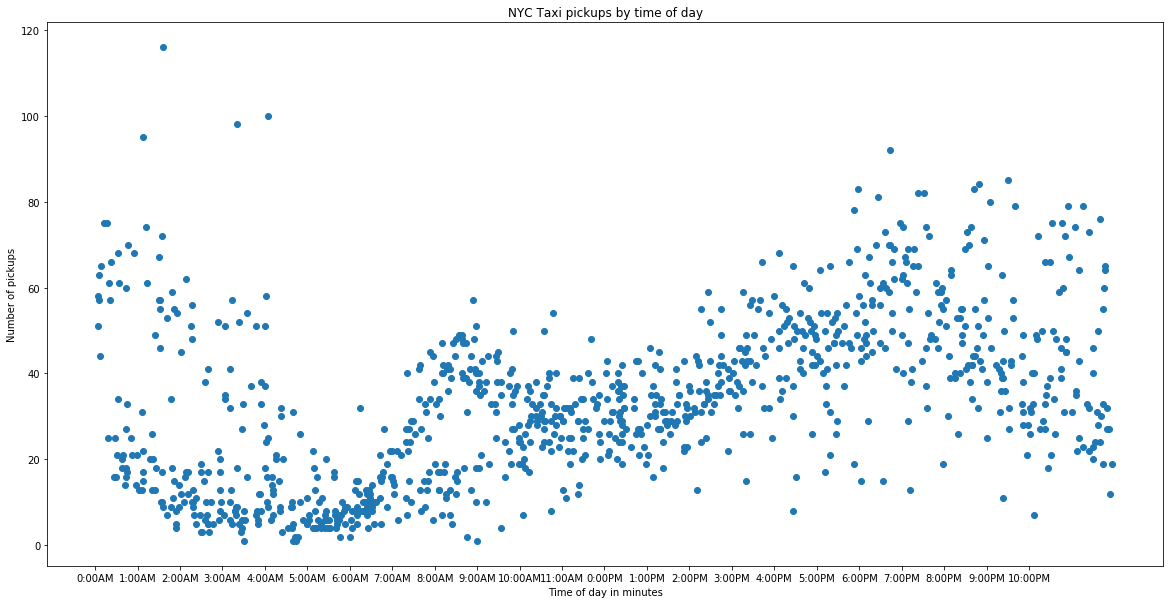

In [6]:
def convert_hours(minutes):
    minutes = int(minutes)
    return '%d:%s%s' % ((minutes / 60) % 12, str(minutes % 60).zfill(2), 'AM' if minutes < 720 else 'PM')

time = []
for t_min in range(0, 1440, 60):
    time.append(convert_hours(t_min))
    #print ('%d min is %s' % (t_min, convert_hours(t_min))) 

plt.rcParams["figure.figsize"] = (20,10)
plt.scatter(train_data['TimeMin'].values, train_data['PickupCount'].values)
plt.xlabel('Time of day in minutes')
plt.ylabel('Number of pickups')
plt.title('NYC Taxi pickups by time of day')
plt.xticks(np.arange(0, 1380, step=60),time)
plt.show()

**1.3 In a few sentences, describe the general pattern of taxi pickups over the course of the day and explain why this is a reasonable result.**

Peak taxi time should be in the mid- to late evening (1100-1440 min), with spikes around the times when restaurants and clubs close (around 12am-2am, or 0-120 min). This matches our observations in the scatter plot. In addition, we would expect a minor peak around the time when people are going to work, which should be around 6:30-8:30am, or 390-510min. This expected spike also appears in the plot.

**1.4 You should see a *hole* in the scatter plot when `TimeMin` is 500-550 minutes...**

In [7]:
subset = df.loc[(df['TimeMin'] >= 500) & (df['TimeMin'] <= 550)].sort_values(by='TimeMin')
subset['TimeHours'] = [convert_hours(x) for x in subset['TimeMin']]
print(subset)

      TimeMin  PickupCount TimeHours
46      501.0         13.0    8:21AM
1150    501.0         41.0    8:21AM
1037    501.0          7.0    8:21AM
1235    503.0         39.0    8:23AM
189     504.0          5.0    8:24AM
419     506.0         47.0    8:26AM
233     507.0         41.0    8:27AM
82      508.0         44.0    8:28AM
980     509.0         37.0    8:29AM
805     509.0         16.0    8:29AM
776     510.0         12.0    8:30AM
523     510.0         48.0    8:30AM
120     511.0         15.0    8:31AM
76      511.0         15.0    8:31AM
227     511.0         17.0    8:31AM
681     515.0         49.0    8:35AM
1045    518.0         48.0    8:38AM
901     519.0         49.0    8:39AM
354     519.0         40.0    8:39AM
649     520.0         47.0    8:40AM
160     520.0         39.0    8:40AM
298     520.0         12.0    8:40AM
50      522.0         18.0    8:42AM
167     524.0         47.0    8:44AM
398     524.0         39.0    8:44AM
281     525.0          2.0    8:45AM
5

Looking at the subset data above, we see either low or high values for identical times. The simplest explanation is that this is peak commuting time, so the low numbers represent Sat/Sun and the high numbers represent weekdays. We could take this into account for our model if weekday is also an available predictor.

<hr>

### <div class="exercise"> <b>Question 2 [25 pts]</b> </div>

In lecture we've seen k-Nearest Neighbors (k-NN) Regression, a non-parametric regression technique.  In the following problems please use built in functionality from `sklearn` to run k-NN Regression. 


**2.1**. Choose `TimeMin` as your feature variable and `PickupCount` as your response variable.  Create a dictionary of `KNeighborsRegressor` objects and call it `KNNModels`.  Let the key for your `KNNmodels` dictionary be the value of $k$ and the value be the corresponding `KNeighborsRegressor` object. For $k \in \{1, 10, 75, 250, 500, 750, 1000\}$, fit k-NN regressor models on the training set (`train_data`). 

**2.2**.  For each $k$, overlay a scatter plot of the actual values of `PickupCount` vs. `TimeMin` in the training set with a scatter plot of **predictions** for `PickupCount` vs  `TimeMin`.  Do the same for the test set.  You should have one figure with 7 x 2 total subplots; for each $k$ the figure should have two subplots, one subplot for the training set and one for the test set. 

**Hints**:
1. Each subplot should use different color and/or markers to distinguish k-NN regression prediction values from the actual data values.
2. Each subplot must have appropriate axis labels, title, and legend.
3. The overall figure should have a title.  


**2.3**. Report the $R^2$ score for the fitted models on both the training and test sets for each $k$ (reporting the values in tabular form is encouraged).

**2.4**. Plot, in a single figure, the $R^2$ values from the model on the training and test set as a function of $k$.  

**Hints**:
1. Again, the figure must have axis labels and a legend.
2. Differentiate $R^2$ plots on the training and test set by color and/or marker.
3. Make sure the $k$ values are sorted before making your plot.

**2.5**. Discuss the results:

1. If $n$ is the number of observations in the training set, what can you say about a k-NN regression model that uses $k = n$?  
2. What does an $R^2$ score of $0$ mean?  
3. What would a negative $R^2$ score mean?  Are any of the calculated $R^2$ you observe negative?
4. Do the training and test $R^2$ plots exhibit different trends?  Describe.  
5. What is the best value of $k$?  How did you come to choose this value?  How do the corresponding training/test set $R^2$ values compare?
6. Use the plots of the predictions (in 2.2) to justify why your choice of the best $k$ makes sense (**Hint**: think Goldilocks).

### Answers

**2.1 Choose `TimeMin` as your feature variable and `PickupCount` as your response variable.  Create a dictionary...** 

In [8]:
def single_pred(df):
    return df.values.reshape(-1, 1)

def fitKNN(k, data):
    knr = KNeighborsRegressor(n_neighbors=k)
    knr.fit(single_pred(data['TimeMin']), data['PickupCount'].values)
    return knr

KNNmodels = dict()
k_vals = [1, 10, 75, 250, 500, 750, 1000]
for k in k_vals:
    KNNmodels[k] = fitKNN(k, train_data)

**2.2  For each $k$, overlay a scatter plot of the actual values of `PickupCount` vs. `TimeMin` in the training set...**

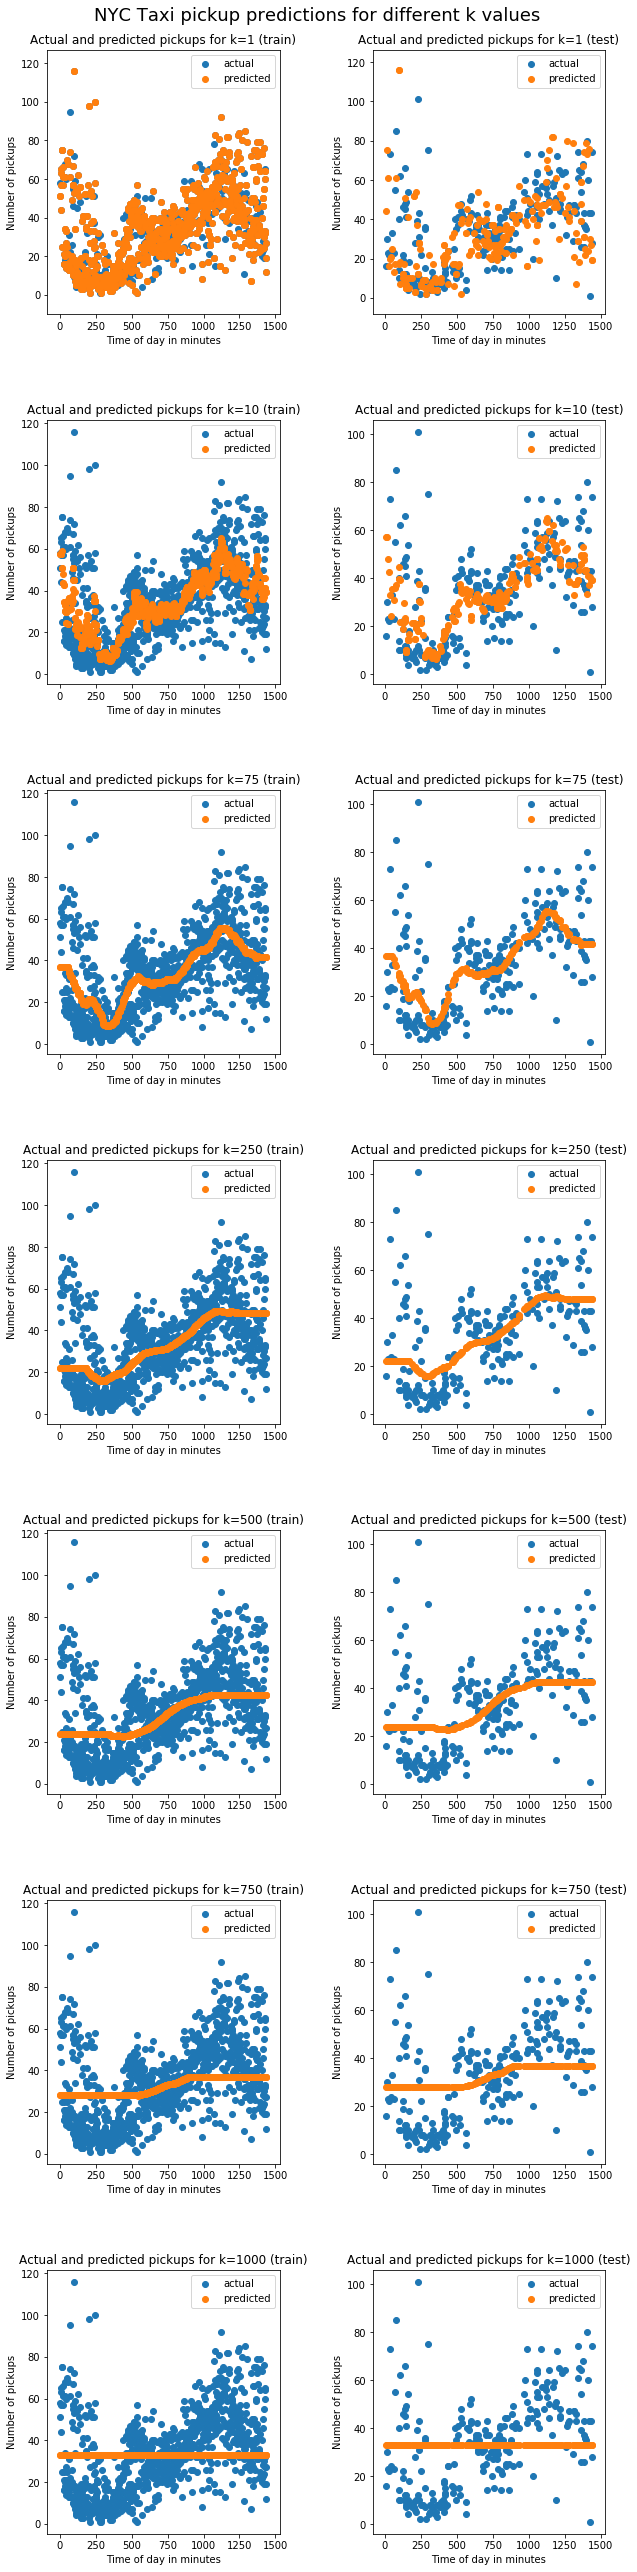

In [27]:
i = 1
plt.figure(figsize=(10, 12))
predictions = {'train': dict(), 'test': dict()}
for k in k_vals:
    for t in ['train', 'test']:
        plt.subplot(7, 2, i)
        i += 1
        data = {'train': train_data, 'test': test_data}[t]
        predictions[t][k] = KNNmodels[k].predict(single_pred(data['TimeMin']))
        plt.scatter(data['TimeMin'].values, data['PickupCount'].values)
        plt.scatter(data['TimeMin'].values, predictions[t][k])
        plt.xlabel('Time of day in minutes')
        plt.ylabel('Number of pickups')
        plt.title("Actual and predicted pickups for k=%d (%s)" % (k, t))
        plt.legend(['actual', 'predicted'])
plt.subplots_adjust(top=3, wspace=0.4, hspace=0.4)
plt.suptitle("NYC Taxi pickup predictions for different k values", fontsize=18, x=.5, y=3.05)
plt.show()

**2.3 Report the $R^2$ score for the fitted models on both the training and test sets for each $k$ (reporting the values in tabular form is encouraged).**


In [9]:
r2 = pd.DataFrame(columns=['k', 'Type', 'R-squared'])
for k in k_vals:
    for t in ['train', 'test']:
        data = {'train': train_data, 'test': test_data}[t]
        r2 = r2.append({'k': k,
                        'Type': t,
                        'R-squared': r2_score(data['PickupCount'].values, predictions[t][k])},
                       ignore_index=True)

display(r2)

,k,Type,R-squared
0,1,train,0.712336
1,1,test,-0.418932
2,10,train,0.509825
3,10,test,0.272068
4,75,train,0.445392
5,75,test,0.390310
6,250,train,0.355314
7,250,test,0.340341
8,500,train,0.290327
9,500,test,0.270321


**2.4 Plot, in a single figure, the $R^2$ values from the model on the training and test set as a function of $k$.**  

Text(0.5, 1.0, 'R-squared versus k-value')

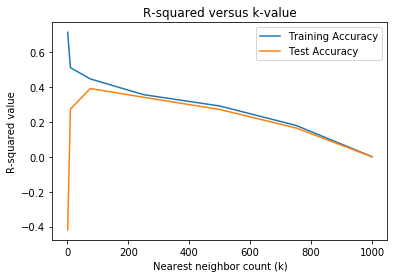

In [10]:
tr, tst = r2.loc[r2['Type'] == 'train'], r2.loc[r2['Type'] == 'test']
plt.plot(tr['k'].values, tr['R-squared'].values)
plt.plot(tst['k'].values, tst['R-squared'].values)
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel("Nearest neighbor count (k)")
plt.ylabel('R-squared value')
plt.title('R-squared versus k-value')

**2.5 Discuss the results:**

1. If $n$ is the number of observations in the training set, what can you say about a k-NN regression model that uses $k = n$?  

When $k = n$, the prediction is simply the mean, since all data points are used.

2. What does an $R^2$ score of $0$ mean?  

An $R^2$ of $0$ indicates that there is no linear correlation between the feature(s) and the response; this is what we would expect to observe if the data were entirely uncorrelated, or if our model were so poor as to be no more predictive than using the mean of the data. Of course, this is approximately what we see for $k=1000$.

3. What would a negative $R^2$ score mean?  Are any of the calculated $R^2$ you observe negative?

A negative $R^2$ indicates negative linear correlation: in other words, that the model predicts even worse than the mean. We see a negative score for $k=1$ on the test set, which indicates severe overfitting to our training data.

4. Do the training and test $R^2$ plots exhibit different trends?  Describe.  

The training $R^2$ plot starts at a high value and drops as $k$ increases, which we would expect given that our KNN model is fitting very closely to the training data at low $k$. The test plot exhibits a very different trend, with $R^2$ starting negative, rising to a peak around $k=75$, and falling off to converge with the training plot at high values of $k$. This makes sense because training and test error should converge as $k$ rises, but when the value is too high, the KNN model reverts towards a simple mean prediction, yielding worse $R^2$ values on both training and test data.

5. What is the best value of $k$?  How did you come to choose this value?  How do the corresponding training/test set $R^2$ values compare?

$k=75$ yields the best test $R^2$ value, and is therefore the best value for this data set. The training and test $R^2$ values are fairly close together, with test slightly lower than training. The $R^2$ divergence drops as $k$ rises. 

6. Use the plots of the predictions (in 2.2) to justify why your choice of the best $k$ makes sense (**Hint**: think Goldilocks).** ****

In this case, our Goldilocks principle would suggest that the best $k$ value achieves relatively high test $R^2$ with relatively low difference between training and test $R^2$ values. In other words, it captures the training distribution well, but still demonstrates a capacity to generalize.

<hr>

### <div class="exercise"> <b> Question 3 [25 pts] </b></div>

We next consider simple linear regression, which we know from lecture is a parametric approach for regression that assumes that the response variable has a linear relationship with the predictor.  Use the `statsmodels` module for Linear Regression. This module has built-in functions to summarize the results of regression and to compute confidence intervals for estimated regression parameters.  

**3.1**. Again choose `TimeMin` as your predictor and `PickupCount` as your response variable.  Create an `OLS` class instance and use it to fit a Linear Regression model on the training set (`train_data`).  Store your fitted model in the variable `OLSModel`.

**3.2**. Create a plot just like you did in 2.2 (but with fewer subplots): plot both the observed values and the predictions from `OLSModel` on the training and test set. You should have one figure with two subplots, one subplot for the training set and one for the test set.

**Hints**:
1. Each subplot should use different color and/or markers to distinguish Linear Regression prediction values from that of the actual data values.
2. Each subplot must have appropriate axis labels, title, and legend.
3. The overall figure should have a title.  


**3.3**. Report the $R^2$ score for the fitted model on both the training and test sets.

**3.4**. Report the estimates for the slope and intercept for the fitted linear model.  

**3.5**. Report the $95\%$ confidence intervals (CIs) for the slope and intercept.  

**3.6**. Discuss the results:

1. How does the test $R^2$ score compare with the best test $R^2$ value obtained with k-NN regression?  Describe why this is not surprising for these data.
2. What does the sign of the slope of the fitted linear model convey about the data?  
3. Interpret the $95\%$ confidence intervals from 3.5.  Based on these CIs is there evidence to suggest that the number of taxi pickups has a significant linear relationship with time of day?  How do you know? 
4. How would $99\%$ confidence intervals for the slope and intercept compare to the $95\%$ confidence intervals (in terms of midpoint and width)?  Briefly explain your answer.  
5. Based on the data structure, what restriction on the model would you put at the endpoints (at $x\approx0$ and $x\approx1440$)?   What does this say about the appropriateness of a linear model?


### Answers

**3.1 Again choose `TimeMin` as your predictor and `PickupCount` as your response variable...**

In [44]:
train_data_X = sm.add_constant(train_data['TimeMin'])
model = OLS(train_data['PickupCount'], train_data_X)

**3.2 Create a plot just like you did in 2.2 (but with fewer subplots)...** 

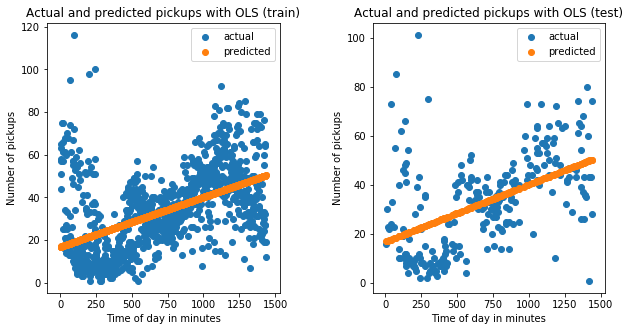

In [45]:
results = model.fit()
i = 1
plt.figure(figsize=(10, 2))
plt.subplots_adjust(top=2, wspace=0.4, hspace=0.4)
OLS_predictions = dict()
for t in ['train', 'test']:
    plt.subplot(1, 2, i)
    i += 1
    data = {'train': train_data, 'test': test_data}[t]
    data_X = sm.add_constant(data['TimeMin'])
    OLS_predictions[t] = results.predict(data_X)
    plt.scatter(data['TimeMin'].values, data['PickupCount'].values)
    plt.scatter(data['TimeMin'].values, OLS_predictions[t])
    plt.xlabel('Time of day in minutes')
    plt.ylabel('Number of pickups')
    plt.title("Actual and predicted pickups with OLS (%s)" % t)
    plt.legend(['actual', 'predicted'])

**3.3 Report the $R^2$ score for the fitted model on both the training and test sets.**


In [46]:
for t in ['train', 'test']:
    data = {'train': train_data, 'test': test_data}[t]
    print("R-squared for %s is %f" % (t, r2_score(data['PickupCount'].values, OLS_predictions[t])))

R-squared for train is 0.243026
R-squared for test is 0.240662


**3.4 Report the estimates for the slope and intercept for the fitted linear model.**

In [51]:
print(results.summary())
print("Slope is %.3f" % results.params['TimeMin'])
print("Intercept is %.2f" % results.params['const'])

                            OLS Regression Results                            
Dep. Variable:            PickupCount   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     320.4
Date:                Sun, 22 Sep 2019   Prob (F-statistic):           2.34e-62
Time:                        19:27:38   Log-Likelihood:                -4232.9
No. Observations:                1000   AIC:                             8470.
Df Residuals:                     998   BIC:                             8480.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.7506      1.058     15.838      0.0

**3.5 Report the $95\%$ confidence intervals (CIs) for the slope and intercept.** 


In [62]:
c_se, t_se = results.bse['const'], results.bse['TimeMin']
slope, intercept = results.params['TimeMin'], results.params['const']
print("95%% confidence interval for slope is [%.4f, %.4f]" % (slope - t_se, slope + t_se))
print("95%% confidence interval for intercept is [%.2f, %.2f]" % (intercept - c_se, intercept + c_se))

95% confidence interval for slope is [0.0220, 0.0246]
95% confidence interval for intercept is [15.69, 17.81]


**3.6 Discuss the results:**

1. How does the test $R^2$ score compare with the best test $R^2$ value obtained with k-NN regression?  Describe why this is not surprising for these data.

The $R^2$ value is quite low compared to that for kNN, which is natural given that the data is highly nonlinear and exhibits strong local dependencies.

2. What does the sign of the slope of the fitted linear model convey about the data?  

Generally speaking, the later in the day it is, the more pickups we should expect.


3. Interpret the $95\%$ confidence intervals from 3.5.  Based on these CIs is there evidence to suggest that the number of taxi pickups has a significant linear relationship with time of day?  How do you know? 


Since the CIs do not contain 0 in either case, we can be confident at the 95% level that the number of taxi pickups is positively correlated with the time of day.


4. How would $99\%$ confidence intervals for the slope and intercept compare to the $95\%$ confidence intervals (in terms of midpoint and width)?  Briefly explain your answer.  


The 99% confidence intervals would have the same midpoint but a significantly greater width - by just over half a standard error on each side, since the z-score for 95% confidence is 1.96 and that for 99% is 2.58.

5. Based on the data structure, what restriction on the model would you put at the endpoints (at $x\approx0$ and $x\approx1440$)?   What does this say about the appropriateness of a linear model?

$x\approx0$ and $x\approx1440$ represent the same time on successive days, and therefore our predictions for the two should be the same if the day within the week is unknown. The fact that the linear model shows a statistically significant positive slope thus provides a further confirmation that the linear model is inappropriate.

<hr>

## <div class="theme"> Outliers </div>

You may recall from lectures that OLS Linear Regression can be susceptible to outliers in the data.  We're going to look at a dataset that includes some outliers and get a sense for how that affects modeling data with Linear Regression.  **Note, this is an open-ended question, there is not one correct solution (or even one correct definition of an outlier).**


### <div class="exercise"><b> Question 4 [30 pts] </b></div>




**4.1**. We've provided you with two files `outliers_train.csv` and `outliers_test.csv` corresponding to training set and test set data.  What does a visual inspection of training set tell you about the existence of potential outliers in the data?

**4.2**. Choose `X` as your feature variable and `Y` as your response variable.  Use `statsmodel` to create a Linear Regression model on the training set data.  Store your model in the variable `OutlierOLSModel`.

**4.3**. You're given the knowledge ahead of time that there are 3 outliers in the training set data.  The test set data doesn't have any outliers.  You want to remove the 3 outliers in order to get the optimal intercept and slope.  In the case that you're sure of the existence and number (3) of outliers ahead of time, one potential brute force method to outlier detection might be to find the best Linear Regression model on all possible subsets of the training set data with 3 points removed.  Using this method, how many times will you have to calculate the Linear Regression coefficients on the training data?

**4.4**  Construct an approximate algorithm to find a user-specified number of outlier candidates in the training data. Place your algorithm in the function `find_outliers_simple`.  It should take the parameters `dataset_x`, `dataset_y`, and `num_outliers` representing your features, response variable values (make sure your response variable is stored as a numpy column vector), and the number of outliers to remove.  Your algorithm should select the `num_outliers` most extreme residuals from the linear regression model to predict, `dataset_y` from `dataset_x`.  The return value should be a list `outlier_indices` representing the indices of the `num_outliers` outliers in the original datasets you passed in.  Apply your function to the training data in order to identify 3 outliers.  Use `statsmodels` to create a Linear Regression model on the remaining training set data (with the 3 outliers removed), and store your model in the variable `OutlierFreeSimpleModel`.

**4.5** Create a figure with two subplots: the first is a scatterplot where the color of the points denotes the outliers from the non-outliers in the training set, and include two regression lines on this scatterplot: one fitted with the outliers included and one fitted with the outlier removed (all on the training set).  The second plot should include a scatterplot of points from the test set with the same two regression lines fitted on the training set: with and without outliers.  Visually which model fits the test set data more closely?

**4.6**. Calculate the $R^2$ score for the `OutlierOLSModel` and the `OutlierFreeSimpleModel` on the test set data.  Which model produces a better $R^2$ score?

**4.7**. One potential problem with the brute force outlier detection approach in 4.3 and the heuristic algorithm you constructed 4.4 is that they assume prior knowledge of the number of outliers.  In general you can't expect to know ahead of time the number of outliers in your dataset.  Propose how you would alter and/or use the algorithm you constructed in 4.4 to create a more general heuristic (i.e. one which doesn't presuppose the number of outliers) for finding outliers in your dataset.  

**Hints**:
   1. Should outliers be removed one at a time or in batches?
   2. What metric would you use and how would you use it to determine how many outliers to consider removing?

### Answers
**4.1  We've provided you with two files `outliers_train.txt` and `outliers_test.txt` corresponding to training set and test set data.  What does a visual inspection of training set tell you about the existence of outliers in the data?** 

In [6]:
# read the data
# your code here


*your answer here*
  


**4.2 Choose `X` as your feature variable and `Y` as your response variable.  Use `statsmodel` to create a Linear Regression model on the training set data.  Store your model in the variable `OutlierOLSModel`.**



In [7]:
# your code here


**4.3 You're given the knowledge ahead of time that there are 3 outliers...Using this method, how many times will you have to calculate the Linear Regression coefficients on the training data?**
  

*your answer here*


**4.4  Construct an approximate algorithm to find a user-specified number of outlier candidates in the training data...**

In [10]:
def find_outliers_simple(dataset_x, dataset_y, num_outliers):
    # your code here
    
    
    return list(outlier_indices)

In [8]:
# get outliers and calculate outlier model
# your code here


**4.5 Create a figure with two subplots: the first is a scatterplot where the color of the points...**


In [9]:
# plot 
# your code here



*your answer here*


**4.6 Calculate the $R^2$ score for the `OutlierOLSModel` and the `OutlierFreeSimpleModel` on the test set data.  Which model produces a better $R^2$ score?**


In [10]:
# your code here


**4.7 One potential problem with the brute force outlier detection approach in 4.3 and the heuristic algorithm you constructed 4.4 is that they assume prior knowledge of the number of outliers...**

*your answer here*
